In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import ollama
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import re
import requests
from tqdm import tqdm
import time

In [2]:
df = pd.read_csv('./data/manually_labelled.csv')
# print(df.head(2))

print('Length of DF: ', len(df))
print(df.isna().sum())

Length of DF:  246
category            146
post_date           146
post_title          146
comment_date        146
comment_votes       146
comment_body         69
comment_stance      181
comment_argument    169
dtype: int64


In [3]:
print(df.notna().sum())

category            100
post_date           100
post_title          100
comment_date        100
comment_votes       100
comment_body        177
comment_stance       65
comment_argument     77
dtype: int64


In [4]:
def clean_text(text):
    if isinstance(text, str):
        text = re.sub(r'\[.*?\]\(.*?\)', '', text)  
        text = re.sub(r'[^a-zA-Z0-9\s.,!?]', '', text)  
        text = re.sub(r'\s+', ' ', text)
        return text.strip()
    return ''

def filter_bot(text):
    return isinstance(text, str) and 'i am a bot' in text.lower() #iamabot' in re.sub(r'\s+', '', text)

In [5]:
count = 0
for idx, text in df['comment_body'].items():
    cleaned_text = clean_text(text)
    if filter_bot(cleaned_text):
        count += 1
        print(cleaned_text)
        df.drop(idx, inplace=True)

print(count)

I am a bot, and this action was performed automatically. Please if you have any questions or concerns.
I am a bot, and this action was performed automatically. Please if you have any questions or concerns.
I am a bot. Any complaints suggestions to rContextualBot thanks
I am a bot, and this action was performed automatically. Please if you have any questions or concerns.
I am a bot, and this action was performed automatically. Please if you have any questions or concerns.
5


In [6]:
len(df[df['comment_body'].isna() & df['comment_stance'].isna()])

69

In [7]:
df[df['comment_stance'].isna() & df['comment_body'].notna()]['comment_body']

0      Snapshot of _Minister failing to act to reduce...
2      An archived version can be found [here](https:...
8      The amount of money wasted on completely bollo...
10     I once worked on a project that installed a ha...
15     So in other words smaller employers don’t need...
                             ...                        
234    We all know that ultimately the facts are that...
238    They just leave it.  You've got senior doctors...
240    People earning 50k will not bother applying fo...
242                       Is it incompetence?  Laziness?
245    Today's academia has so many failings - it act...
Name: comment_body, Length: 107, dtype: object

In [8]:
df = df[~df['comment_stance'].isna()]

In [9]:
df['comment_stance']

6      disapprove
11     disapprove
12     disapprove
13     disapprove
17     disapprove
          ...    
223       approve
232       approve
235    disapprove
236       approve
243       approve
Name: comment_stance, Length: 65, dtype: object

In [10]:
df['comment_body'] = df['comment_body'].apply(clean_text)

In [11]:
df['new_stance'] = df['comment_stance'].replace({'approve': 'agree', 'disapprove': 'disagree'})

In [12]:
print(df['comment_stance'].value_counts())
print(df['new_stance'].value_counts())

comment_stance
disapprove    43
approve       22
Name: count, dtype: int64
new_stance
disagree    43
agree       22
Name: count, dtype: int64


In [13]:
def strip_content(text):
    text = re.sub(r'[^A-Za-z0-9\s]', '', text.lower())

    try:
        stance_index = text.index('stance')
    except ValueError:
        stance_index = 0

    try:
        arg_index = text.index('rationale')
    except ValueError:
        arg_index = 0


    if arg_index>stance_index:
        stance_text = text[stance_index:arg_index]
    else:
        stance_text = text[stance_index:]

    stance = 'disapprove' if 'disagree' in stance_text else 'approve'
    # stance = 'disagree' if 'disagree' in stance_text else 'agree'
    # stance = 'disagree' if 'no' in stance_text else 'agree'

    argument = text[arg_index:].split(' ')
    
    try:
        argument.remove('rationale')
    except:
        pass

    argument = ' '.join(argument)

    # stat_index = text.index('strategy')
    
    # stat = text[stat_index:].split(' ')
    # stat.remove('strategy')
    # stat = ' '.join(stat)

    return stance, argument#, stat

def strip_recheck(text):
    text = re.sub(r'[^A-Za-z0-9\s]', '', text.lower())
    if 'yes' in text:
        return True 
    else:
        return False

In [18]:
# LLM prompt template
def response_prompt(title, comment):
    return f"""You are an expert in political discourse analysis.

    Post Title: "{title}"
    Comment: "{comment}"

    Task 1: Does the comment AGREE or DISAGREE with the opinion expressed in the title? Reply only with 'agree', 'disagree'.

    Task 2: Briefly explain the rationale behind the comment in 1-2 sentences.

    Respond in the following format:
    Stance: <stance>
    Rationale: <explanation>
    """

def recheck_prompt(title, comment, response):
    res_dict = {
        'approve': 'agree',
        'disapprove': 'disagree'
    }
    response = res_dict[response]
    return f"""
    Post Title: "{title}
    Comment: "{comment}"
    AI Response: "{response}"

    The AI response says the comment {response} with the post title, is this correct?

    Respond with only yes or no
    """



def query_ollama(prompt, mdl_idx):
    models_dict = { 0: 'gemma3:12b', 1: 'gemma3:4b', 2: 'deepseek-r1:8b'}
    url = "http://localhost:11434/api/generate"
    data = {
        "model": models_dict[mdl_idx],
        "prompt": prompt,
        "stream": False
    }
    try:
        response = requests.post(url, json=data)
        response.raise_for_status()
        return response.json()["response"]
    except Exception as e:
        print("Error:", e)
        return None

In [21]:
def apply_on_df(df):
    selected_mdl_idx = 0
    for idx, row in tqdm(df.iterrows(), desc='Processing: ', total=len(df), dynamic_ncols=True):
        prompt = response_prompt(row['post_title'], row['comment_body'])
        llm_response = query_ollama(prompt, selected_mdl_idx) 

        if llm_response:
            stance, argument = strip_content(llm_response)
            check_prompt = recheck_prompt(row['post_title'], row['comment_body'], stance)
            llm_check_response = query_ollama(check_prompt, selected_mdl_idx)
            llm_check_flag = strip_recheck(llm_check_response)

            # print('LLM Response: \n', llm_response)
            # print('LLM Check Response: \n', llm_check_response)
            # print('Check Flag: ', llm_check_flag)

            if not llm_check_flag:
                stance2 = 'disapprove' if stance=='approve' else 'approve'

            df.at[idx, 'llm_stance'] = stance.lower() 
            df.at[idx, 'llm_stance2'] = stance2.lower()
            df.at[idx, 'llm_argument'] = argument.lower() 
   
        time.sleep(1)

    return df

In [22]:
result_df = apply_on_df(df)
result_df.to_csv('data/llm_labelled_2.csv')

Processing: 100%|██████████| 65/65 [10:30<00:00,  9.69s/it]


In [23]:
ytrue, ypred = result_df['comment_stance'], result_df['llm_stance'].map(str.lower)
acc_score = accuracy_score(ytrue, ypred)
clf_report = classification_report(ytrue, ypred)
cm = confusion_matrix(ytrue, ypred)

print('Accuracy Score (Gemma3:12b)-recheck-v1:', acc_score)
print('classification Report:')
print(clf_report)

Accuracy Score (Gemma3:12b)-recheck-v1: 0.8153846153846154
classification Report:
              precision    recall  f1-score   support

     approve       0.66      0.95      0.78        22
  disapprove       0.97      0.74      0.84        43

    accuracy                           0.82        65
   macro avg       0.81      0.85      0.81        65
weighted avg       0.86      0.82      0.82        65



In [25]:
ytrue, ypred = result_df['comment_stance'], result_df['llm_stance2'].map(str.lower)
acc_score = accuracy_score(ytrue, ypred)
clf_report = classification_report(ytrue, ypred)
cm = confusion_matrix(ytrue, ypred)

print('Accuracy Score (Gemma3:12b)-recheck-v1:', acc_score)
print('classification Report:')
print(clf_report)

Accuracy Score (Gemma3:12b)-recheck-v1: 0.3230769230769231
classification Report:
              precision    recall  f1-score   support

     approve       0.28      0.64      0.39        22
  disapprove       0.47      0.16      0.24        43

    accuracy                           0.32        65
   macro avg       0.37      0.40      0.32        65
weighted avg       0.40      0.32      0.29        65



<Axes: >

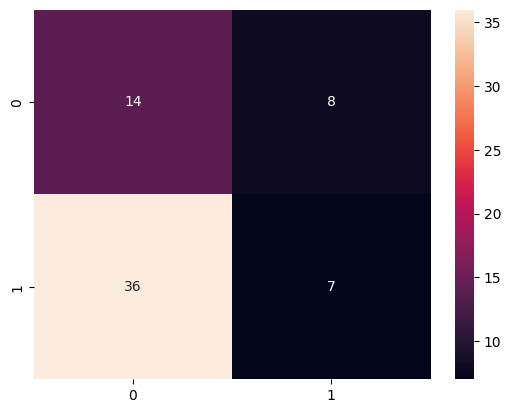

In [26]:
sns.heatmap(cm, annot=True)

In [16]:
ytrue, ypred = result_df['comment_stance'], result_df['llm_stance'].map(str.lower)
acc_score = accuracy_score(ytrue, ypred)
clf_report = classification_report(ytrue, ypred)
cm = confusion_matrix(ytrue, ypred)

print('Accuracy Score (DeepSeek-R1:8b):', acc_score)
print('classification Report:')
print(clf_report)

Accuracy Score (DeepSeek-R1:8b): 0.7076923076923077
classification Report:
              precision    recall  f1-score   support

     approve       0.56      0.68      0.61        22
  disapprove       0.82      0.72      0.77        43

    accuracy                           0.71        65
   macro avg       0.69      0.70      0.69        65
weighted avg       0.73      0.71      0.71        65



In [128]:
result_df = pd.read_csv('./data/llm_labelled.csv')
ytrue, ypred = result_df['comment_stance'], result_df['llm_stance'].map(str.lower)
acc_score = accuracy_score(ytrue, ypred)
clf_report = classification_report(ytrue, ypred)
cm = confusion_matrix(ytrue, ypred)

print('Accuracy Score (Gemma3:12b):', acc_score)
print('classification Report:')
print(clf_report)

Accuracy Score (Gemma3:12b): 0.8153846153846154
classification Report:
              precision    recall  f1-score   support

     approve       0.67      0.91      0.77        22
  disapprove       0.94      0.77      0.85        43

    accuracy                           0.82        65
   macro avg       0.80      0.84      0.81        65
weighted avg       0.85      0.82      0.82        65



In [16]:
ytrue, ypred = result_df['comment_stance'], result_df['llm_stance'].map(str.lower)
acc_score = accuracy_score(ytrue, ypred)
clf_report = classification_report(ytrue, ypred)
cm = confusion_matrix(ytrue, ypred)

print('Accuracy Score (Gemma3:12b) - prompt - v1:', acc_score)
print('classification Report:')
print(clf_report)

Accuracy Score (Gemma3:12b) - prompt - v1: 0.7692307692307693
classification Report:
              precision    recall  f1-score   support

     approve       0.61      0.91      0.73        22
  disapprove       0.94      0.70      0.80        43

    accuracy                           0.77        65
   macro avg       0.77      0.80      0.76        65
weighted avg       0.83      0.77      0.78        65



In [67]:
# result_df['llm_stance'] = result_df['llm_stance'].map({'disapprove':'disagree'})
# result_df['llm_stance'].value_counts()
result_df = pd.read_csv('./data/llm_labelled.csv')
result_df['llm_stance'] = result_df['llm_stance'].replace({'disapprove': 'disagree', 'approve': 'approve'})
result_df['llm_stance'].value_counts()

llm_stance
disagree    33
agree       32
Name: count, dtype: int64

In [68]:
ytrue, ypred = result_df['new_stance'], result_df['llm_stance'].map(str.lower)
acc_score = accuracy_score(ytrue, ypred)
clf_report = classification_report(ytrue, ypred)
cm = confusion_matrix(ytrue, ypred)

print('Accuracy Score (Gemma3:12b) - prompt - v0 - new_stance:', acc_score)
print('classification Report:')
print(clf_report)

Accuracy Score (Gemma3:12b) - prompt - v0 - new_stance: 0.8153846153846154
classification Report:
              precision    recall  f1-score   support

       agree       0.66      0.95      0.78        22
    disagree       0.97      0.74      0.84        43

    accuracy                           0.82        65
   macro avg       0.81      0.85      0.81        65
weighted avg       0.86      0.82      0.82        65



In [90]:
result_df['llm_stance'].value_counts()

llm_stance
agree       35
disagree    30
Name: count, dtype: int64

In [92]:
ytrue, ypred = result_df['new_stance'], result_df['llm_stance'].map(str.lower)
acc_score = accuracy_score(ytrue, ypred)
clf_report = classification_report(ytrue, ypred)
cm = confusion_matrix(ytrue, ypred)

print('Accuracy Score (Gemma3:12b) - prompt - v2 - new_stance:', acc_score)
print('classification Report:')
print(clf_report)

Accuracy Score (Gemma3:12b) - prompt - v2 - new_stance: 0.7384615384615385
classification Report:
              precision    recall  f1-score   support

       agree       0.57      0.91      0.70        22
    disagree       0.93      0.65      0.77        43

    accuracy                           0.74        65
   macro avg       0.75      0.78      0.73        65
weighted avg       0.81      0.74      0.74        65



In [32]:
import re
import requests
import time
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


def clean_text(text):
    if isinstance(text, str):
        text = re.sub(r'\[.*?\]\(.*?\)', '', text)  
        text = re.sub(r'[^a-zA-Z0-9\s.,!?]', '', text)  
        text = re.sub(r'\s+', ' ', text)
        return text.strip()
    return ''

def filter_bot(text):
    return isinstance(text, str) and 'i am a bot' in text.lower() #iamabot' in re.sub(r'\s+', '', text)

def strip_content(text):
    text = re.sub(r'[^A-Za-z0-9\s]', '', text.lower())

    try:
        stance_index = text.index('stance')
    except ValueError:
        stance_index = 0

    try:
        arg_index = text.index('rationale')
    except ValueError:
        arg_index = len(text)

    if arg_index > stance_index:
        stance_text = text[stance_index:arg_index]
    else:
        stance_text = text[stance_index:]

    stance = 'disapprove' if 'disagree' in stance_text else 'approve'

    argument = text[arg_index:].split(' ')
    try:
        argument.remove('rationale')
    except:
        pass
    argument = ' '.join(argument)

    return stance, argument

# Prompt templates
def response_prompt(title, comment):
    return f"""You are an expert in political discourse analysis.

    Post Title: "{title}"
    Comment: "{comment}"

    Task 1: Does the comment AGREE or DISAGREE with the opinion expressed in the title? Reply only with 'agree', 'disagree'.

    Task 2: Briefly explain the rationale behind the comment in 1-2 sentences.

    Respond in the following format:
    Stance: <stance>
    Rationale: <explanation>
    """

def query_ollama(prompt, mdl_idx):
    models_dict = {0: 'gemma3:12b', 1: 'gemma3:4b', 2: 'deepseek-r1:8b'}
    url = "http://localhost:11434/api/generate"
    data = {
        "model": models_dict[mdl_idx],
        "prompt": prompt,
        "stream": False
    }
    try:
        response = requests.post(url, json=data)
        response.raise_for_status()
        return response.json()["response"]
    except Exception as e:
        print("Error:", e)
        return ""

def apply_on_df(df):
    selected_mdl_idx = 0
    for idx, row in tqdm(df.iterrows(), desc='Processing', total=len(df), dynamic_ncols=True):
        # First pass
        prompt1 = response_prompt(row['post_title'], row['comment_body'])
        response1 = query_ollama(prompt1, selected_mdl_idx)
        stance1, arg1 = strip_content(response1)

        # Second independent recheck (no yes/no)
        prompt2 = response_prompt(row['post_title'], row['comment_body'])
        response2 = query_ollama(prompt2, selected_mdl_idx)
        stance2, arg2 = strip_content(response2)

        df.at[idx, 'llm_stance'] = stance1
        df.at[idx, 'llm_argument'] = arg1
        df.at[idx, 'llm_stance2'] = stance2
        df.at[idx, 'llm_argument2'] = arg2

        df.at[idx, 'llm_stance3'] = stance1 if stance1==stance2 else stance2

        time.sleep(1)

    return df


def load_process_df():
    df = pd.read_csv('./data/manually_labelled.csv')

    for idx, text in df['comment_body'].items():
        cleaned_text = clean_text(text)
        if filter_bot(cleaned_text):
            df.drop(idx, inplace=True)

    df = df[~df['comment_stance'].isna()]
    df['comment_body'] = df['comment_body'].apply(clean_text)

    return df 

def save_log(acc_scores):
    file_path = './data/log.txt'
    with open(file_path, 'w') as f:
        f.write(
            f"\nAccuracy : {":.2f".format(acc_scores[0])}\nAccuracy : {":.2f".format(acc_scores[1])}\nAccuracy : {":.2f".format(acc_scores[2])}"
        )

    


df = load_process_df()
result_df = apply_on_df(df)

In [33]:
# 
y_true, ypred1, ypred2, ypred3 = result_df['comment_stance'], result_df['llm_stance'], result_df['llm_stance2'], result_df['llm_stance3']
acc_score1 = accuracy_score(y_true, ypred1)
acc_score2 = accuracy_score(y_true, ypred2)
acc_score3 = accuracy_score(y_true, ypred3)
save_log([acc_score1, acc_score2, acc_score3])

print([acc_score1, acc_score2, acc_score3])

[0.8153846153846154, 0.8153846153846154, 0.8153846153846154]


In [31]:
result_df.to_csv('./data/llm_labelled_2405.csv')

In [34]:
def load_process_df():
    df = pd.read_csv('./data/manually_labelled.csv')

    for idx, text in df['comment_body'].items():
        cleaned_text = clean_text(text)
        if filter_bot(cleaned_text):
            df.drop(idx, inplace=True)

    df = df[~df['comment_stance'].isna()]
    df['comment_body'] = df['comment_body'].apply(clean_text)

    return df 

cleaned_df = load_process_df()
cleaned_df.to_csv('./data/cleaned_data.csv')